In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# PreProcessing

In [3]:
file_rki = "/content/drive/My Drive/DataScience/Week8/RKI_COVID19.csv"

In [4]:
df_rki = pd.read_csv(file_rki)

In [5]:
df_rki.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,12548163,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"16.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,12548164,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"16.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,12548165,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"16.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,12548166,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"16.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,12548167,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"16.06.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


In [6]:
np.unique(df_rki["Bundesland"])

array(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'], dtype=object)

In [7]:
df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])

In [8]:
def calculate_sumcases_bundesland(df_rki):

  state_data = {}
  uni_states = np.unique(df_rki["Bundesland"])

  for state in uni_states:
    print(state)
    df_state = df_rki[df_rki.Bundesland == state]
    df_state = df_state.sort_values(by=['Meldedatum'])
    df_state = df_state[["AnzahlFall","Meldedatum"]].groupby(by="Meldedatum").sum()

    sum_up = 0
    for i in range(len(df_state["AnzahlFall"])):
      sum_up                += df_state["AnzahlFall"][i]
      df_state["AnzahlFall"][i] = sum_up 
    
    state_data[state] = df_state

  return(state_data)

In [9]:
state_data = calculate_sumcases_bundesland(df_rki)

Baden-Württemberg
Bayern
Berlin
Brandenburg
Bremen
Hamburg
Hessen
Mecklenburg-Vorpommern
Niedersachsen
Nordrhein-Westfalen
Rheinland-Pfalz
Saarland
Sachsen
Sachsen-Anhalt
Schleswig-Holstein
Thüringen


In [10]:
state_data["Brandenburg"]

,AnzahlFall
Meldedatum,
2020-03-01,1
2020-03-05,3
2020-03-08,7
2020-03-09,11
2020-03-10,20
...,...
2020-06-10,3320
2020-06-11,3325
2020-06-12,3329


In [11]:
def create_all_statedf(state_data):
  uni_states = list(state_data.keys())
  df = pd.DataFrame()

  for state in uni_states:
    data_dict = {}
    data_dict = { 'State_Cases': state_data[state]["AnzahlFall"] , "State" : np.repeat(state,len(state_data[state]), axis=0)}
    df_state  = pd.DataFrame(data=data_dict)
    df_state  = df_state.reset_index()
    df = df.append(pd.DataFrame(data = df_state), ignore_index=True)

  return(df)


In [12]:
df_state_data = create_all_statedf(state_data)

#Example Plot

In [13]:
df_state_data.tail()

,Meldedatum,State_Cases,State
1636,2020-06-11,3155,Thüringen
1637,2020-06-12,3161,Thüringen
1638,2020-06-13,3171,Thüringen
1639,2020-06-14,3174,Thüringen
1640,2020-06-15,3175,Thüringen


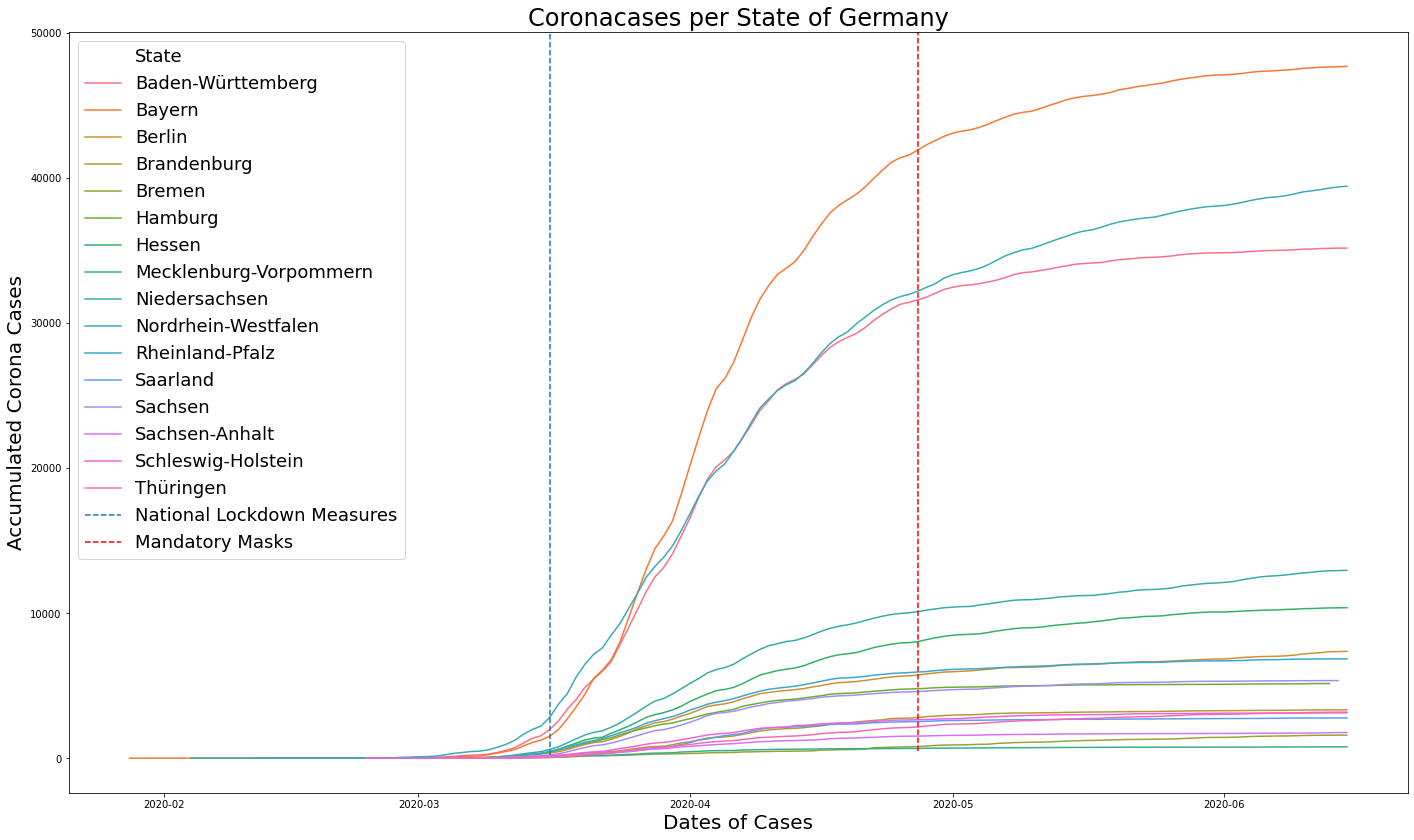

In [14]:
plt.figure(figsize = (24,14))
#sns.set(style='darkgrid',)
 
# Draw line plot of size and total_bill with parameters and hue "day"
ax = sns.lineplot(x = "Meldedatum", y = "State_Cases", data = df_state_data, hue = "State")
 
plt.title("Coronacases per State of Germany", fontsize = 24)
plt.ylabel("Accumulated Corona Cases", fontsize = 20)
plt.xlabel("Dates of Cases", fontsize = 20)
plt.axvline(x=df_state_data["Meldedatum"][23],ymin=0.05,linestyle="dashed",label='National Lockdown Measures')# Implementing general lockdown measures
plt.axvline(x=df_state_data["Meldedatum"][65],color="red",ymin=0.055,linestyle="dashed",label='Mandatory Masks')# Implementing general masks for all people
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22')
plt.legend(prop={'size': 18})
plt.show()

In [15]:
state_data["Bayern"]

,AnzahlFall
Meldedatum,
2020-01-28,2
2020-01-29,4
2020-01-31,7
2020-02-03,8
2020-02-04,11
...,...
2020-06-11,47567
2020-06-12,47607
2020-06-13,47628


In [35]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [54]:
def create_prediction_dataframe(state_data):
  df = pd.DataFrame()
  uni_states = list(state_data.keys())
  for state in uni_states:
    df_data  = state_data[state].reset_index()
    df_data.columns = ["ds","y"]
    df_data.head()
    prophet_basic = Prophet()
    prophet_basic.fit(df_data)
    future= prophet_basic.make_future_dataframe(periods=14)
    forecast=prophet_basic.predict(future)
    forecast_30 = forecast

    data_dict = {}
    data_dict = { 'Date': forecast_30["ds"] ,"Trend": forecast_30["yhat"], "State" : np.repeat(state,len(forecast_30), axis=0)}
    df_state  = pd.DataFrame(data=data_dict)
    df_state  = df_state.reset_index()
    df = df.append(pd.DataFrame(data = df_state), ignore_index=True)

  return(df)

In [55]:
test = create_prediction_dataframe(state_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Timestamp('2020-06-16 00:00:00')

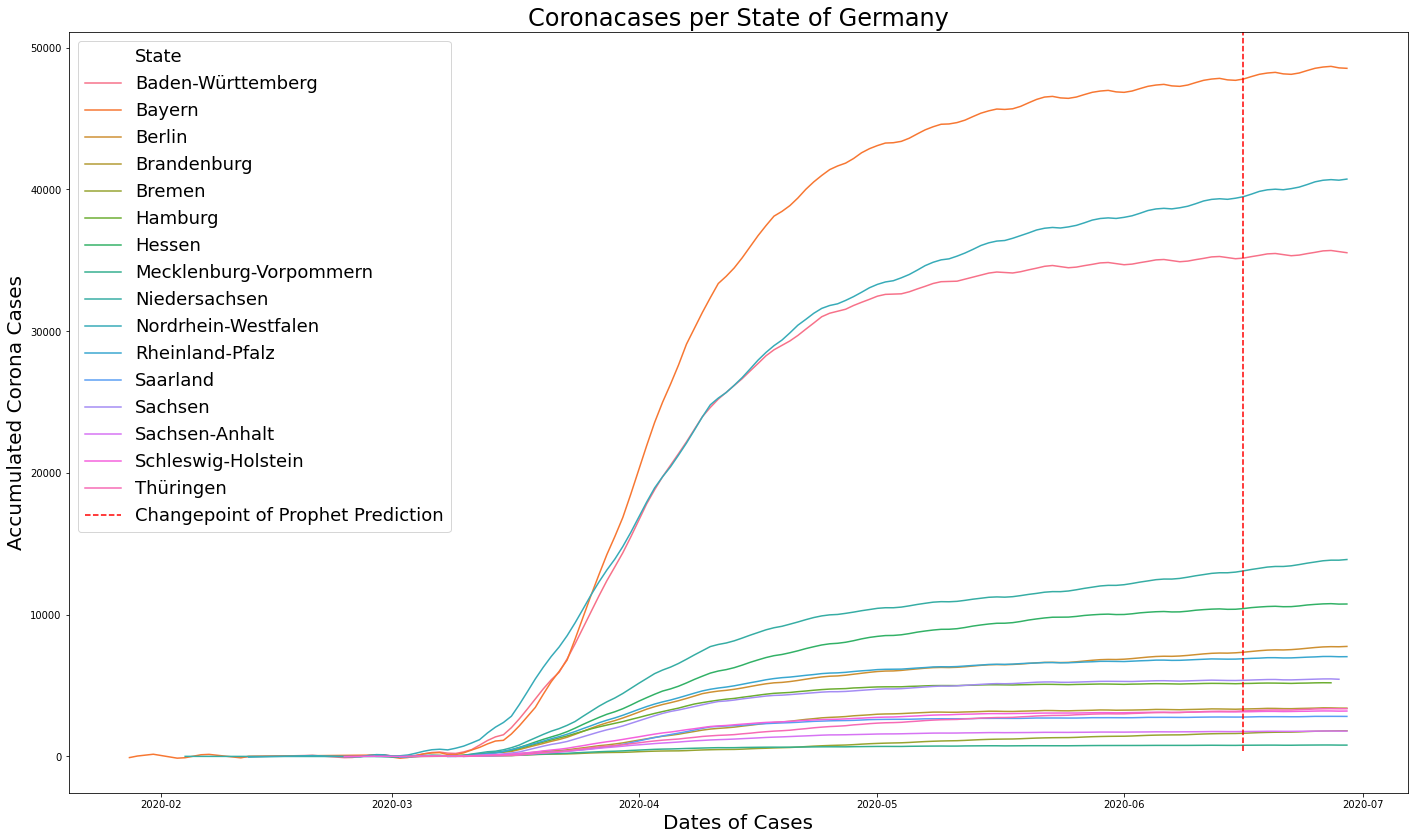

In [66]:
plt.figure(figsize = (24,14))
#sns.set(style='darkgrid',)
 
# Draw line plot of size and total_bill with parameters and hue "day"
ax = sns.lineplot(x = "Date", y = "Trend", data = test, hue = "State")
 
plt.title("Coronacases per State of Germany", fontsize = 24)
plt.ylabel("Accumulated Corona Cases", fontsize = 20)
plt.xlabel("Dates of Cases", fontsize = 20)
#plt.axvline(x=df_state_data["Meldedatum"][23],ymin=0.05,linestyle="dashed",label='National Lockdown Measures')# Implementing general lockdown measures
plt.axvline(x=test["Date"][1851],color="red",ymin=0.055,linestyle="dashed",label='Changepoint of Prophet Prediction')# Implementing general masks for all people
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22')
plt.legend(prop={'size': 18})
plt.show()